In [23]:
# fixes import err
import os
os.chdir("../../")

In [24]:
import argparse
import binascii
import logging
import os
import random
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import sys
from pathlib import Path
from typing import Optional
import pdb

import numpy as np
import torch
import torch.nn.functional as F  # noqa
import torch.optim as optim
import tqdm
from ignite.contrib.handlers import TensorboardLogger
from ignite.contrib.handlers.tensorboard_logger import GradsHistHandler
from ignite.contrib.handlers.tqdm_logger import ProgressBar
from ignite.engine import create_supervised_evaluator
from ignite.engine import create_supervised_trainer
from ignite.engine import Engine
from ignite.engine import Events
from ignite.handlers import Checkpoint
from ignite.handlers import DiskSaver
from ignite.handlers import global_step_from_engine
from ignite.metrics import Loss
from ignite.metrics import RunningAverage
from ignite.utils import convert_tensor
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler

from src.data.dataset import T4CDataset, train_collate_fn

import matplotlib.pyplot as plt
from PIL import Image

from sklearn.metrics import mean_squared_error

from pytorch_wavelets import DWTForward, DWTInverse # (or import DWT, IDWT)
import matplotlib.animation as animation

from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from hydra.utils import instantiate
from omegaconf import OmegaConf

from clearml import Dataset, Task

In [25]:
perm = np.array([[0,1,2,3,4,5,6,7],
        [2,3,4,5,6,7,0,1],
        [4,5,6,7,0,1,2,3],
        [6,7,0,1,2,3,4,5]
        ])
# dynamic_input_mean = np.load('/data/processed/dynamic_input_mean.npy')
# dynamic_input_std = np.load('/data/processed/dynamic_input_std.npy')

# dynamic_input_mean = torch.from_numpy(dynamic_input_mean)[None, None, :, None, None].float()
# dynamic_input_std = torch.from_numpy(dynamic_input_std)[None, None, :, None, None].float()


def reset_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    import io
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img.convert('RGB')

def get_ani(mat):
    fig, ax = plt.subplots(figsize=(8, 8))
    imgs = []
    for img in mat:
        img = ax.imshow(img, animated=True)
        imgs.append([img])
    ani = animation.ArtistAnimation(fig, imgs, interval=1000, blit=True, repeat_delay=3000)
    return ani.to_html5_video()

def plot_tmaps(true, pred, viz_dir, logger):
    for dir in viz_dir:
        fig = plt.figure(figsize=(50, 35))

        # setting values to rows and column variables
        rows = 2
        columns = pred.shape[0]
        for t_step in range(pred.shape[0]):

            # reading images


            # Adds a subplot at the 1st position
            fig.add_subplot(rows, columns, t_step+1)

            # showing image
            _ = plt.imshow(pred[t_step,:,:,dir])
            plt.axis('off')

        plt.title("pred")

        for t_step in range(true.shape[0]):

            # Adds a subplot at the 1st position
            fig.add_subplot(rows, columns, t_step+pred.shape[0]+1)
            # showing image
            _ = plt.imshow(true[t_step,:,:,dir])
            plt.axis('off')

        plt.title("true")
        plt.close()

        logger.current_logger().report_image("viz", "images", iteration=dir, image=fig2img(fig))

        logger.current_logger().report_media(
                "viz", "true frames", iteration=dir, stream=get_ani(true[:,:,:,dir]), file_extension='html')

        logger.current_logger().report_media(
                "viz", "pred frames", iteration=dir, stream=get_ani(pred[:,:,:,dir]), file_extension='html')


def plot_dims(logger, true_series, pred_series, dim=8):

    x = list(range(true_series.shape[0]))

    for i in range(0, true_series.shape[-1]):
        logger.current_logger().report_scatter2d(
        str(i),
        "true",
        iteration=0,
        scatter=np.dstack((x, true_series[:,i])).squeeze(),
        xaxis="t",
        yaxis="count",
        mode='lines+markers'
    )
        logger.current_logger().report_scatter2d(
            str(i),
            "pred",
            iteration=0,
            scatter=np.dstack((x, pred_series[:,i])).squeeze(),
            xaxis="t",
            yaxis="count",
            mode='lines+markers'
        )


def unstack_on_time(data: torch.Tensor, batch_dim:bool = False, num_channels=4, crop= None):
        """
        `(k, 12 * 8, 495, 436) -> (k, 12, 495, 436, 8)`
        """
        _, _, height, width = data.shape
        if not batch_dim:
            # `(12, 495, 436, 8) -> (1, 12, 495, 436, 8)`
            data = torch.unsqueeze(data, 0)

        num_time_steps = int(data.shape[1] / num_channels)
        # (k, 12 * 8, 495, 436) -> (k, 12, 8, 495, 436)
        data = torch.reshape(data, (data.shape[0],
                                    num_time_steps,
                                    num_channels,
                                    height,
                                    width))
        if crop is not None:
            left, right, top, bottom = crop
            right = width - right
            bottom = height - bottom
            data = data[:, :,:, top:bottom, left:right]

        #data = (data+dynamic_input_mean)*dynamic_input_std
        # (k, 12, 8, 495, 436) -> (k, 12, 495, 436, 8)
        data = torch.moveaxis(data, 2, 4)

        if not batch_dim:
            # `(1, 12, 495, 436, 8) -> (12, 495, 436, 8)`
            data = torch.squeeze(data, 0)
        return data

def prepare_data(batch, dynamic_channels, out_channels, transform_p, switch=None):
        in_h = transform_p['in_h']
        in_w = transform_p['in_w']
        is_static = transform_p['static']
        pad_tuple = tuple(transform_p['pad_tuple'])
        if is_static == True:
            dynamic_channels = dynamic_channels - 9
        dynamic, static, target  = batch
        static = static.float()
        #dynamic = (dynamic - dynamic_input_mean) / dynamic_input_std
        dynamic = dynamic.reshape(-1, dynamic_channels, in_h, in_w)
        if switch is not None:
            dynamic = dynamic[:,switch.flatten(),:,:]

        #target = target.reshape(-1, out_channels, in_h, in_w)
        #target = F.pad(target, pad=pad_tuple)
        if is_static:
            input_batch = torch.cat([dynamic, static], dim=1)
        else:
            input_batch = dynamic

        input_batch = F.pad(input_batch, pad=pad_tuple)

        #target = (target - dynamic_input_mean) / dynamic_input_std

        return input_batch, target

In [26]:
reset_seeds(123)
task = Task.init(project_name="t4c", task_name="Residual Data Gen")
logger = task.get_logger()
args = {
    'task_id': '0e4025d9ded54281898b14ab4f0fa7c9',
    'data_dir': './data/processed/resid128/',
    'batch_size': 1,
    'num_workers': 1,
    'loader': 'val',
    'num_channels': 8,
    'viz_dir': [0,1,2,3],
}

ClearML Task: created new task id=ac19dcd5e5f24b0dba99cb23b7fddef6
ClearML results page: http://10.40.21.187:8080/projects/5924ac614e65461a96a5fa84531306f9/experiments/ac19dcd5e5f24b0dba99cb23b7fddef6/output/log


In [27]:
task.connect(args)
print ('Arguments: {}'.format(args))

# get OmegaConf file from ClearML and parse
train_task = Task.get_task(task_id=args['task_id'])
cfg = train_task.get_configuration_object("OmegaConf")
cfg = OmegaConf.create(cfg)
print (cfg)
cfg.model.dataset.root_dir = "7days"
# instantiate model
try:
    root_dir = Dataset.get(dataset_project="t4c", dataset_name=cfg.model.dataset.root_dir).get_local_copy()
except:
    print("Could not find dataset in clearml server. Exiting!")

if cfg.model.dataset.perm == True:
    is_perm = True
    cfg.model.dataset.perm = False
    cfg.model.dataset.single_channel = None
else:
    is_perm = False
model = instantiate(cfg.model, dataset={"root_dir":root_dir})
model_path = train_task.artifacts['model_checkpoint'].get_local_copy()
network = model.network
network = network.to('cuda')
#model_path = "/data/t5chx.pt"
#model_state_dict = torch.load(model_path)
model_state_dict = torch.load(model_path+'/'+os.listdir(model_path)[0])#,map_location=torch.device('cpu'))
network.load_state_dict(model_state_dict['train_model'])
network.eval()

Arguments: {'task_id': '0e4025d9ded54281898b14ab4f0fa7c9', 'data_dir': './data/processed/resid128/', 'batch_size': 1, 'num_workers': 1, 'loader': 'val', 'num_channels': 8, 'viz_dir': [0, 1, 2, 3]}
{'model': {'_target_': 'src.models.model.Model', 'network': {'_target_': 'src.models.unet.UNet', 'in_channels': 48, 'out_channels': 48, 'depth': 2, 'wf': 6, 'padding': True, 'up_mode': 'upconv', 'batch_norm': True, 'pos_emb': False}, 'dataset': {'_target_': 'src.data.dataset.T4CDataset', 'root_dir': '7days', 'limit': None, 'use_npy': False, 'sampling_height': 1, 'sampling_width': 1, 'dim_start': 0, 'dim_step': 1, 'output_start': 0, 'output_step': 1, 'reduced': False, 'single_channel': None, 'time_step': None, 'perm': False}, 'valset': True, 'valset_limit': None, 'val_filter': '**/validation/*8ch.h5'}, 'train': {'random_seed': 123, 'train_fraction': 1, 'val_fraction': 0, 'resume_checkpoint': None, 'epochs': 20, 'parallel_backend': 'nccl', 'n_process': 4, 'amp_mode': 'amp', 'scaler': True, 'opt

UNet(
  (down_path): ModuleList(
    (0): UNetConvBlock(
      (block1): Block(
        (proj): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (act): ReLU()
        (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (block2): Block(
        (proj): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (act): ReLU()
        (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (res_conv): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): UNetConvBlock(
      (block1): Block(
        (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (act): ReLU()
        (norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (block2): Block(
        (proj): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (act): ReLU()
        (norm): Batch

In [46]:
m = model.network
# store parameters of last layer of m as a numpy array
last_layer = m.last.weight.data.cpu().numpy()

In [48]:
last_layer.shape

(6, 8, 64, 1, 1)

In [47]:
last_layer = last_layer.reshape((6, 8, 64, 1, 1))

In [ ]:
points = []
for i in range(6):
    #plt.scatter(list(range(48)), last_layer[:,i,:,:])
    points.append(last_layer[i, 0, :])

In [ ]:
# set list colors to a random set of 8 color names
colors = ['red', 'green', 'blue', 'orange', 'purple', 'yellow', 'black', 'pink']



In [68]:
wghts.shape

(6, 64)

In [70]:
# print without scientific notation
np.set_printoptions(suppress=True)
wghts[:2, :12]

array([[ 0.07373782, -0.01200841, -0.03954924, -0.09278487, -0.05867691,
        -0.08610501,  0.11729972, -0.00917817,  0.05059931, -0.00001747,
        -0.01343948, -0.06934188],
       [ 0.13687737,  0.05271666, -0.05817172,  0.04897249, -0.07522623,
        -0.02434591,  0.07765026, -0.05162975,  0.02313561,  0.0222594 ,
         0.0616708 , -0.12206775]], dtype=float32)

In [74]:
# Generate a 64 dimensional vector of random positive numbers
sample = np.random.rand(1, 64)
print (1- spatial.distance.cosine(sample[0], wghts[0]))

0.07215056099801975


2023-01-22 17:15:45,500 - clearml.Task - ERROR - Action failed <400/110: tasks.add_or_update_artifacts/v2.10 (Invalid task status: expected=created, status=stopped)> (task=48525c72684d404da1cb3cc1f9827506, artifacts=[{'key': 'state', 'type': 'dict', 'uri': 'http://10.40.21.187:8081/t4c/residuals128.48525c72684d404da1cb3cc1f9827506/artifacts/state/state.json', 'content_size': 41678, 'hash': '2989c5289f00c81bf9f9adb7cdbd5d5ffbdf72b152e56602cf3c980f66ca16d6', 'timestamp': 1674379855, 'type_data': {'preview': 'Dataset state\nFiles added/modified: 128 - total size 11.33 GB\nCurrent dependency graph: {\n  "48525c72684d404da1cb3cc1f9827506": []\n}\n', 'content_type': 'application/json'}, 'display_data': [('files added', '128'), ('files removed', '0'), ('files modified', '0')]}, {'key': 'data', 'type': 'custom', 'uri': 'http://10.40.21.187:8081/t4c/residuals128.48525c72684d404da1cb3cc1f9827506/artifacts/data/dataset.48525c72684d404da1cb3cc1f9827506.c663bjuc.zip', 'content_size': 1224653765, 'h

In [54]:
# print cosine distance between every pair of points in wghts using scipy.spatial.distance.cosine
from scipy import spatial
for i in range(6):
    for j in range(6):
        print("cosine distance between point {} and point {} is {}".format(i, j, 1 - spatial.distance.cosine(wghts[i], wghts[j])))

cosine distance between point 0 and point 0 is 1
cosine distance between point 0 and point 1 is 0.5302127003669739
cosine distance between point 0 and point 2 is 0.3560185134410858
cosine distance between point 0 and point 3 is 0.462667316198349
cosine distance between point 0 and point 4 is 0.3038874566555023
cosine distance between point 0 and point 5 is 0.3388156592845917
cosine distance between point 1 and point 0 is 0.5302127003669739
cosine distance between point 1 and point 1 is 1
cosine distance between point 1 and point 2 is 0.5248415470123291
cosine distance between point 1 and point 3 is 0.4151257574558258
cosine distance between point 1 and point 4 is 0.44254910945892334
cosine distance between point 1 and point 5 is 0.36829203367233276
cosine distance between point 2 and point 0 is 0.3560185134410858
cosine distance between point 2 and point 1 is 0.5248415470123291
cosine distance between point 2 and point 2 is 1
cosine distance between point 2 and point 3 is 0.24819995462

In [49]:
wghts = last_layer[:, 0, :, 0, 0]
# check cosine distance between 

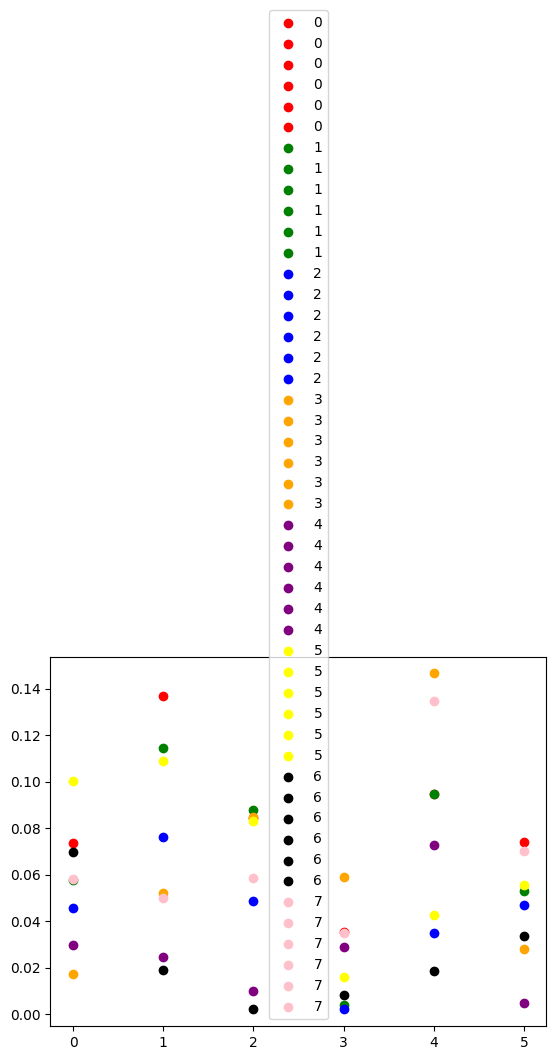

In [ ]:
# plot the first channel of last_layer
for j in range(8):
    for i in range(6):
    #plt.scatter(list(range(48)), last_layer[:,i,:,:])
        plt.scatter(i, np.linalg.norm(last_layer[i,j,0,0], ord=2), c=colors[j], label=str(j))
plt.legend()

In [ ]:
bs = args['batch_size']
d = args['num_channels']
#dataloader_config = configs[model_str].get("dataloader_config", {})

g = torch.Generator()
g.manual_seed(123)

if args['loader'] == 'train':
    loader = DataLoader(model.t_dataset, batch_size=bs, num_workers=args['num_workers'], worker_init_fn=seed_worker, generator=g, shuffle=False, collate_fn=train_collate_fn)
else:
    loader = DataLoader(model.v_dataset, batch_size=bs, num_workers=args['num_workers'], worker_init_fn=seed_worker, generator=g, shuffle=False, collate_fn=train_collate_fn)
print ('Dataloader first few files: {}'.format(loader.dataset.file_list[:10]))

Dataloader first few files: [PosixPath('/home/shehel/.clearml/cache/storage_manager/datasets/ds_5f3da1841f384f83bfbf8b4ca426f641/MOSCOW/validation/2019-01-04_MOSCOW_8ch.h5'), PosixPath('/home/shehel/.clearml/cache/storage_manager/datasets/ds_5f3da1841f384f83bfbf8b4ca426f641/MOSCOW/validation/2019-01-11_MOSCOW_8ch.h5'), PosixPath('/home/shehel/.clearml/cache/storage_manager/datasets/ds_5f3da1841f384f83bfbf8b4ca426f641/MOSCOW/validation/2019-03-01_MOSCOW_8ch.h5'), PosixPath('/home/shehel/.clearml/cache/storage_manager/datasets/ds_5f3da1841f384f83bfbf8b4ca426f641/MOSCOW/validation/2019-03-17_MOSCOW_8ch.h5'), PosixPath('/home/shehel/.clearml/cache/storage_manager/datasets/ds_5f3da1841f384f83bfbf8b4ca426f641/MOSCOW/validation/2019-04-06_MOSCOW_8ch.h5'), PosixPath('/home/shehel/.clearml/cache/storage_manager/datasets/ds_5f3da1841f384f83bfbf8b4ca426f641/MOSCOW/validation/2019-06-19_MOSCOW_8ch.h5'), PosixPath('/home/shehel/.clearml/cache/storage_manager/datasets/ds_5f3da1841f384f83bfbf8b4ca426

In [ ]:
import ipdb

In [ ]:
def prepare_data(batch, dynamic_channels, out_channels, transform_p, switch=None):
        in_h = transform_p['in_h']
        in_w = transform_p['in_w']
        is_static = transform_p['static']
        pad_tuple = tuple(transform_p['pad_tuple'])
        if is_static == True:
            dynamic_channels = dynamic_channels - 9
        dynamic, static, target, dates  = batch
        #target = dynamic[:, 11:12, switch[0][0]:switch[0][0]+1, :, :] - target
        #dynamic = (dynamic - dynamic_input_mean) / dynamic_input_std

        #post_d = dynamic.clone()
        #post_d[:, :10, 0, :, :] = dynamic[:, 1:11, 0, :, :]

        #pred = average_model.forward(dynamic)
        #target = target - pred
        dynamic = dynamic.reshape(-1, dynamic_channels, in_h, in_w)
        if switch is not None:
            dynamic = dynamic[:,switch.flatten(),:,:]

        #target = target.reshape(-1, out_channels, in_h, in_w)
        #target = F.pad(target, pad=pad_tuple)
        if is_static:
            input_batch = torch.cat([dynamic, static], dim=1)
        else:
            input_batch = dynamic


        input_batch = F.pad(input_batch, pad=pad_tuple)

        # pred = t_model(input_batch.to("cuda"))
        # height, width = pred.shape[-2], pred.shape[-1]
        # left, right, top, bottom = pad_tuple
        # right = width - right
        # bottom = height - bottom
        # pred = pred[:, :, top:bottom, left:right]

        # pred = pred.reshape(-1, 1, 1, 495, 436)
        #pdb.set_trace()
        #post_d[:,-1,0, :,:] = pred[:,0,0,:,:]

        #dynamic = post_d.reshape(-1, dynamic_channels, in_h, in_w)
        #if is_static:
        #    input_batch = torch.cat([dynamic, static], dim=1)
        #else:
        #    input_batch = dynamic
        #input_batch = F.pad(input_batch, pad=pad_tuple)

        #target = (target - dynamic_input_mean) / dynamic_input_std
        input_batch = input_batch.to("cuda")
        dates = dates.to("cuda")
        return [input_batch, dates], target
bs = args['batch_size']
d = args['num_channels']
#dataloader_config = configs[model_str].get("dataloader_config", {})

g = torch.Generator()
g.manual_seed(123)

# make a dummy numpy array of shape (240, 6, 128, 128, 8) to store residuals
residuals = []
residuals_folder = args['data_dir']
for idx, i in (enumerate(loader)):
    i, file_idx = i[:-1], i[-1]
    inp, true = prepare_data(i, cfg.model.network.in_channels,
                                cfg.model.network.out_channels, cfg.train.transform)
    pred = network(inp)
    pred = pred.cpu().detach()

    pred = unstack_on_time(pred, d, num_channels=d,
                                crop = tuple(cfg.train.transform.pad_tuple))
    #true = (true+dynamic_input_mean)*dynamic_input_std
    true = torch.moveaxis(true, 2, 4)
    pred = np.clip(pred, 0, 255)

    
    #print (file_idx)
    # get residual from true and pred and index it by idx and account for batch size bs
    #residuals[idx*bs:(idx+1)*bs, :, :, :, :] = true - pred
    # get residuals and assign it to residual
    residual = true - pred
    # use min-max scaling to scale the residuals from -255 to 255 to 0 to 255
    residual = (residual - (-255)) / (255 - (-255)) * 255
    
    residuals.append(residual)


    # convert residuals to half precision
    if file_idx[0][0] == 239:
        # convert residuals list containing bunch of numpy arrays into one numpy array
        residuals = np.concatenate(residuals, axis=0)
        print (residuals.sum(), residuals.max(), residuals.min())

        residuals = residuals.astype(np.uint8)
        path = residuals_folder + "/".join(str(loader.dataset.file_list[file_idx[0][1]]).split("/")[-3:-1])
        # check if the path to the residuals folder exists, if not create it
        if not os.path.exists(path):
            os.makedirs(path)
        np.save(residuals_folder + "/".join(str(loader.dataset.file_list[file_idx[0][1]]).split("/")[-3:]), residuals)
        print (residuals.sum())
        residuals = []
        print ("saving ", residuals_folder + "/".join(str(loader.dataset.file_list[file_idx[0][1]]).split("/")[-3:]))
            

        # reset residuals to zeros
#plot_dims(logger, trues, preds, d)


24060142000.0 255.0 30.198746
23971433654
saving  ./data/processed/resid128/MOSCOW/validation/2019-01-04_MOSCOW_8ch.h5
24059304000.0 255.0 23.490898
23970421339
saving  ./data/processed/resid128/MOSCOW/validation/2019-01-11_MOSCOW_8ch.h5
24058218000.0 255.0 22.961815
23969536621
saving  ./data/processed/resid128/MOSCOW/validation/2019-03-01_MOSCOW_8ch.h5
24058993000.0 255.0 15.349152
23970320353
saving  ./data/processed/resid128/MOSCOW/validation/2019-03-17_MOSCOW_8ch.h5
24058485000.0 255.0 14.712456
23969941241
saving  ./data/processed/resid128/MOSCOW/validation/2019-04-06_MOSCOW_8ch.h5
24058208000.0 255.0 17.758293
23969454802
saving  ./data/processed/resid128/MOSCOW/validation/2019-06-19_MOSCOW_8ch.h5
24058743000.0 255.0 14.574783
23970084590
saving  ./data/processed/resid128/MOSCOW/validation/2019-06-23_MOSCOW_8ch.h5


In [ ]:
!rsync -av --ignore-existing /home/shehel/.clearml/cache/storage_manager/datasets/ds_5f3da1841f384f83bfbf8b4ca426f641/ ./data/processed/resid128/

sending incremental file list
./
ANTWERP/
ANTWERP/ANTWERP_map_high_res.h5
ANTWERP/ANTWERP_static.h5
ANTWERP/training/
ANTWERP/training/2019-01-05_ANTWERP_8ch.h5
ANTWERP/training/2019-01-12_ANTWERP_8ch.h5
ANTWERP/training/2019-02-22_ANTWERP_8ch.h5
ANTWERP/training/2019-03-08_ANTWERP_8ch.h5
ANTWERP/training/2019-04-29_ANTWERP_8ch.h5
ANTWERP/training/2020-03-08_ANTWERP_8ch.h5
ANTWERP/training/2020-05-08_ANTWERP_8ch.h5
BANGKOK/
BANGKOK/BANGKOK_map_high_res.h5
BANGKOK/BANGKOK_static.h5
BANGKOK/training/
BANGKOK/training/2019-05-17_BANGKOK_8ch.h5
BANGKOK/training/2019-06-03_BANGKOK_8ch.h5
BANGKOK/training/2019-06-18_BANGKOK_8ch.h5
BANGKOK/training/2020-01-05_BANGKOK_8ch.h5
BANGKOK/training/2020-02-10_BANGKOK_8ch.h5
BANGKOK/training/2020-03-23_BANGKOK_8ch.h5
BANGKOK/training/2020-06-05_BANGKOK_8ch.h5
BARCELONA/
BARCELONA/BARCELONA_map_high_res.h5
BARCELONA/BARCELONA_static.h5
BARCELONA/training/
BARCELONA/training/2019-02-02_BARCELONA_8ch.h5
BARCELONA/training/2019-03-14_BARCELONA_8ch.h5
BARC

In [ ]:
# load a resid128 npy file
a = np.load("./data/processed/resid128/ANTWERP/training/2019-01-05_ANTWERP_8ch.h5.npy", )
#b = np.load("./data/processed/resid128/ANTWERP/training/2019-01-12_ANTWERP_8ch.h5.npy")

In [37]:

 # change working directory
os.chdir("/home/shehel/ml/traffic_forecasting")

In [43]:
dataset = Dataset.create(dataset_name='residuals128', dataset_project="t4c")

dataset.add_files(path=residuals_folder)
dataset.upload()
dataset.finalize()


ClearML results page: http://10.40.21.187:8080/projects/5924ac614e65461a96a5fa84531306f9/experiments/6252982d9bd54137a78dbc72ac6b8269/output/log
Generating SHA2 hash for 128 files


100%|██████████| 128/128 [00:14<00:00,  8.90it/s]


Hash generation completed
Uploading dataset changes (20 files compressed to 1.15 GiB) to http://10.40.21.187:8081
Uploading dataset changes (25 files compressed to 1.15 GiB) to http://10.40.21.187:8081
Uploading dataset changes (19 files compressed to 1.14 GiB) to http://10.40.21.187:8081
Uploading dataset changes (19 files compressed to 1.15 GiB) to http://10.40.21.187:8081
Uploading dataset changes (23 files compressed to 1.11 GiB) to http://10.40.21.187:8081
Uploading dataset changes (22 files compressed to 1.12 GiB) to http://10.40.21.187:8081


KeyboardInterrupt: 

In [ ]:
a.min()

-207.9

In [ ]:
kkkkkb

array([[[[[-2.1973e-02, -9.3384e-02, -8.9417e-03, ..., -4.0649e-01,
           -4.9866e-02, -5.5847e-02],
          [ 0.0000e+00, -2.4353e-02,  0.0000e+00, ..., -2.4707e-01,
            0.0000e+00,  0.0000e+00],
          [ 0.0000e+00, -8.8928e-02,  0.0000e+00, ..., -1.2482e-01,
            0.0000e+00, -1.9150e-02],
          ...,
          [-4.5746e-02, -4.9512e-01, -1.2122e-01, ..., -5.8672e+00,
            0.0000e+00, -2.6196e-01],
          [ 0.0000e+00, -4.0332e-01,  0.0000e+00, ..., -8.0176e-01,
            0.0000e+00, -1.3647e-01],
          [ 0.0000e+00,  0.0000e+00, -6.0081e-03, ..., -6.3916e-01,
            0.0000e+00,  0.0000e+00]],

         [[-3.6507e-03, -5.8624e-02,  0.0000e+00, ..., -1.3550e-01,
           -4.0039e-02, -1.0944e-01],
          [ 0.0000e+00, -1.3562e-01,  0.0000e+00, ..., -4.0527e-02,
            0.0000e+00, -2.0361e-01],
          [-3.8177e-02, -1.6174e-01,  0.0000e+00, ..., -7.4158e-03,
            0.0000e+00, -9.6191e-02],
          ...,
          [ 0.